<a href="https://colab.research.google.com/github/sumitmukherjee7/express/blob/master/notebooks/low_level_circuit_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer-Specific Interpretability: Mechanistic Interpretability
**Michael Hanna**

**Notebook Credits:**
This notebook builds on a notebook used in the IEinAI'23 mechanistic interpretability workshop, created by Michael Hanna and Oskar van der Wal. That notebook was in turn based on a [demo notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb), by Neel Nanda, creator of TransformerLens.

---
⚠️**Before starting this notebook:**⚠️
- [ ] Change the runtime to GPU (`Runtime -> Change runtime type -> Hardware Accelator -> GPU`).

## 0 Setup
Just run this code -- don't bother reading it.

In [1]:
%pip install transformer-lens
!wget https://raw.githubusercontent.com/hannamw/eacl-tutorial-resources/main/files/greater-than-data.csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 r

In [2]:
# Import stuff
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from typing import List, Union, Optional, Tuple, Literal
from functools import partial

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, ActivationCache

pio.renderers.default = "colab"
device = "cuda" if torch.cuda.is_available() else "cpu"
if not torch.cuda.is_available():
    print("WARNING: Running on CPU. Did you remember to set your Colab accelerator to GPU?")
torch.set_grad_enabled(False)

## 1 Models in TransformerLens

This tutorial is built with [TransformerLens](https://github.com/neelnanda-io/TransformerLens), a powerful interpretability library for working with pre-trained transformer-based NLP models. TransformerLens allows you to easily interact with model representations and components at a low-level. For example, you can:
- run a forward / backward pass on the model and save attention head outputs, attention patterns, neuron activations, etc.
- intervene on the model during a forward pass, selecting a specific component (attention head, MLP, neuron) and changing its inputs or outputs.

The second point is crucial, as mechanistic interpretability often relies on **causal interventions**: making changes to model internals, and observing changes in model behavior. After we develop a hypothesis, we verify it by making targeted changes to our model, and ensuring that the corresponding behavioral changes are what we expect.

TransformerLens is implemented in PyTorch, so models should feel similar to those you have used before. So far, it supports primarily autoregressive models (e.g., GPT-2). Models must be ported to TransformerLens before use.

### Loading and Running Models
To begin, we will simply load and run a pre-trained model, `gpt2-small`. By setting `model_name` to other values, you can load other models (but this notebook is built for `gpt2-small`). See other valid model names [here](https://neelnanda-io.github.io/TransformerLens/model_properties_table.html).

In [3]:
model_name = 'gpt2-small'
model = HookedTransformer.from_pretrained(model_name, device=device)
model.cfg.use_attn_in = True
model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning:


Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).



config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


Models in TransformerLens run very similarly to HuggingFace Transformers models. Unlike HuggingFace models, however, TransformerLens' HookedTransformers bundle together models and tokenizers. You can access the tokenizer via `model.tokenizer`, but you can also call `model()` directly on strings (or on tokens)!

Try this for yourself, setting `s` to a value of your choice.

In [4]:
s = "Your input sentence here"  #  Change this to a sentence (fragment) of your choice, to see what the next tokens are!
logits = model(s).squeeze(0).cpu()
probs = torch.softmax(logits, dim=-1)

# let's see what the top 5 predictions are
probs, next_tokens = torch.topk(probs[-1], 5)
print(s, "...")
for token_id, prob in zip(next_tokens, probs):
    token = model.tokenizer.decode(token_id.item())
    print(f"{token.strip()}\t {prob.item():.3f}")

Your input sentence here ...
is	 0.248
.	 0.105
will	 0.093
:	 0.061
	 0.058


## 2 The Task: Greater-Than

Now that we've loaded up a model, let's look for a circuit for a specific task! In this tutorial, we'll focus on the greater-than task, which has a known and faithful circuit, but you can replace this with your own as well! For other circuits work, see ...

### 2.1 Loading and viewing the data
For your convenience, we've prepared a pre-made dataset for this task. Each datapoint is a clean sentence, corrupted sentence, and the start year of the event; the corrupted start year is always `01`.

In this dataset, all sentences tokenize to the same length! It's only necessary that each pair of (clean, corrupted) tokenize to the same length, but if all sentences are the same length, you can always assess your metric on the final (-1) token position, instead of taking into account input lengths.

In [5]:
df = pd.read_csv('greater-than-data.csv')
print(df)
print(df.iloc[0])

                                                 clean  \
0    The effect lasted from the year 1282 to the ye...   
1    The tests lasted from the year 1396 to the yea...   
2    The growth lasted from the year 1703 to the ye...   
3    The fall lasted from the year 1723 to the year 17   
4    The shift lasted from the year 1550 to the yea...   
..                                                 ...   
995  The progress lasted from the year 1138 to the ...   
996  The attack lasted from the year 1596 to the ye...   
997  The existence lasted from the year 1721 to the...   
998  The quest lasted from the year 1133 to the yea...   
999  The test lasted from the year 1294 to the year 12   

                                             corrupted  start_year  
0    The effect lasted from the year 1201 to the ye...          82  
1    The tests lasted from the year 1301 to the yea...          96  
2    The growth lasted from the year 1701 to the ye...           3  
3    The fall lasted from t

### 2.2 Measuring Performance
We will measure performance using probability difference (`prob_diff`). This measures the probability assigned to correct years minus the probability assigned to incorrect year. So, for a sentence like "The journey lasted from the year 1577 to the year 15", we would measure the probability assigned to years > 77, minus the probability assigned to years <= 77.

In [6]:
year_indices = torch.tensor([model.tokenizer(f'{year:02d}').input_ids[0] for year in range(100)])

def prob_diff(logits: torch.Tensor, labels: torch.Tensor):
    probs = torch.softmax(logits[:, -1], dim=-1)
    probs = probs[:, year_indices]

    results = []
    for prob, year in zip(probs, labels):
        results.append(prob[year + 1 :].sum() - prob[: year + 1].sum())

    results = torch.stack(results)
    return results

### 2.3 Behavioral Evaluation
Before we start to find a circuit for this task, we should know how our model performs on it! So, we'll measure its peformance according to our metric, across the entire dataset. We'll do this for the clean and corrupted inputs.

In [7]:
def batch_dataset(df, batch_size=8):
    clean, corrupted, label = [df[col].tolist() for col in ['clean', 'corrupted', 'start_year']]
    clean = [clean[i:i+batch_size] for i in range(0, len(df), batch_size)]
    corrupted = [corrupted[i:i+batch_size] for i in range(0, len(df), batch_size)]
    label = [torch.tensor(label[i:i+batch_size]) for i in range(0, len(df), batch_size)]
    return [(clean[i], corrupted[i], label[i]) for i in range(len(clean))]

dataset = batch_dataset(df, batch_size=8)

In [8]:
baseline, corrupted_baseline = [], []
for clean, corrupted, labels in dataset:
    clean_logits = model(clean).cpu()
    baseline.append(prob_diff(clean_logits, labels))

    corrupted_logits = model(corrupted).cpu()
    corrupted_baseline.append(prob_diff(corrupted_logits, labels))

baseline = torch.cat(baseline).mean()
corrupted_baseline = torch.cat(corrupted_baseline).mean()

print(f"Baseline performance: {baseline:.2f}; corrupted performance: {corrupted_baseline:.2f}")

Baseline performance: 0.82; corrupted performance: -0.46


Great! Our model performs well given clean inputs, and quite poorly given corrupted ones. Let's take one last look at its performance on a specific example. We'll see how the model correctly assigns input only to years > the start year.

You can explore different examples by changing the value of `i`

The effect lasted from the year 1282 to the year 12


Text(0.5, 1.0, 'Probability vs. year for start year = 82')

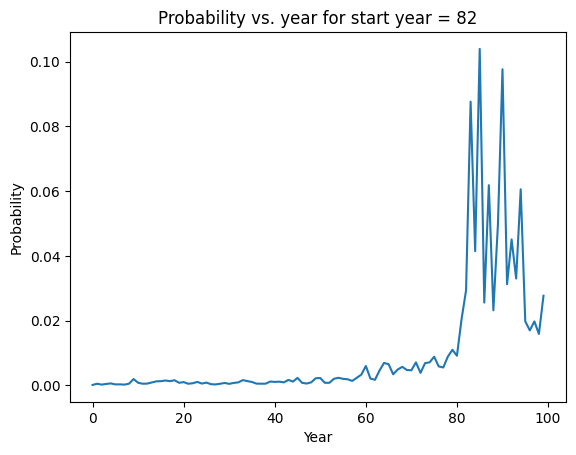

In [9]:
i = 0
print(df['clean'][i])
year_probs = torch.softmax(model(df['clean'][i]).squeeze(0)[-1], dim=-1)[year_indices].cpu()
plt.plot(np.arange(100), year_probs)
plt.ylabel('Probability')
plt.xlabel('Year')
plt.title(f"Probability vs. year for start year = {df['start_year'][i]}")

## 3 Interventions for Circuit Finding
In this section, we'll try to understand how GPT-2 implements greater-than using causal interventions. We'll ablate components and edges in order to see how they contribute to the performance of this task.

### 3.1 Preliminary: How to save and intervene on model components

In order to intervene on model components, TransformerLens introduces `HookPoint`s. A `HookPoint` is an object that wraps the output of a given model component, allowing you to interact with the model's activations. For example, `HookPoint`s exist at the inputs and outputs of each MLP and attention layer, as well as at many intermediate stages thereof.

You can make changes to model activations at a given `HookPoint` by registering a `hook_fn` to it. A `hook_fn` is a function that takes in the activations wrapped by the `HookPoint`, and optionally outputs new values for the activations. During the model's forward pass, the `hook_fn` is called on the activations wrapped by the `HookPoint`; if the `hook_fn` returns a value, this is used as the new value of the activation. In this way, a `hook_fn` can save activations, or intervene on them.

In [10]:
def zero_ablation_hook(activations: torch.Tensor, hook: HookPoint) -> torch.Tensor:
    """
    Zeroes out activations at a given HookPoint
    """
    return torch.zeros_like(activations)

activation_cache = {}
def save_activation_hook(activations: torch.Tensor, hook: HookPoint) -> torch.Tensor:
    """
    Saves activations in a cache but does not intervene on them
    """
    activation_cache[hook.name] = activations.detach()

Each `HookPoint` has a name, telling you where on the model it refers to. We will start by manipulating the outputs of attention heads and MLPs, denoted by `blocks.n.attn.hook_result` and `blocks.n.hook_mlp_out` respectively, where `n` is the layer of the heads / MLP. Note that the activation at `blocks.n.attn.hook_result` contains output for all attention heads, and has size `[batch, position, head, d_model]`; `blocks.n.hook_mlp_out` has size `[batch, position, d_model]`.


<details>
<summary> Click to show a diagram with the names and locations of the `HookPoint`s in a typical TransformerLens HookedTransformer model.</summary>

![big_image](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/gpt2-diagram-annotated.png?raw=true)

**Figure 1:** Left: Schematic of a Transformer model. Middle: More detailed schematic of the Transformer Block. Right: Names of the components in TransformerLens, where the letters (`a`,`b`,`c`, etc.) refer to the annotated components in images on the left. Image adapted from [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Full_GPT_architecture.png/800px-Full_GPT_architecture.png).
</details>


### 3.2 Simple Ablations
Now, we'll learn how to do some of the simpler ablations we learned about, and use them to determine which components are important to the greater-than task.

#### Zero Ablation
For our first ablation, we'll just set the entire MLP / attention head's activation to 0. We'll do this either at all positions (`slice(None, None, None)` is like indexing with `[:]`), or at one of our choice; you can change the value of `position`.

In [11]:
position = slice(None, None, None)
def zero_ablation_hook(activations: torch.Tensor, hook: HookPoint, head_to_ablate=Union[int, Literal['mlp']]) -> torch.Tensor:
    if head_to_ablate == 'mlp':
        activations[:, position] = 0.
    else:
        activations[:, position, head_to_ablate] = 0.
    return activations

def make_zero_ablation_hook(layer: int, head_to_ablate=Union[int, Literal['mlp']]):
    hook_name = f'blocks.{layer}.hook_mlp_out' if head_to_ablate == 'mlp' else f'blocks.{layer}.attn.hook_result'
    return hook_name, partial(zero_ablation_hook, head_to_ablate=head_to_ablate)

Now, try it out! You must select the layer / head that you want to zero ablate, and see how that affects performance. What might be interesting to ablate?

<details><summary> Check the circuit diagram here! </summary>

![Here](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/circuit_diagram_gt41.png?raw=true)

</details>

In [12]:
layer = 0  # Set this to a layer index (0-11)
head = 0  # Set this to a head index (0-11) or to 'mlp'
results = []
for clean, corrupted, labels in dataset:
    cache = model.run_with_cache(corrupted)
    # ablate component
    logits = model.run_with_hooks(clean, fwd_hooks=[make_zero_ablation_hook(layer, head)]).cpu()

    # compute metric on ablated logits
    result = prob_diff(logits, labels)
    results.append(result)

results = torch.cat(results).mean()

print(f"Baseline prob diff was {baseline:0.2f}. Ablating {(layer, head)} yields prob diff {results:.2f}.")

Baseline prob diff was 0.82. Ablating (0, 0) yields prob diff 0.81.


What if we try ablating each head and MLP, one at a time? Iterating over layers and heads / MLP, let's apply a zero ablation to each one. We'll record the prob diff achieved, and subtract the baseline from that; this will tell us how much the ablation caused performance to drop.

In [13]:
all_prob_diffs = torch.zeros((12, 13))
total = 0
for clean, corrupted, labels in dataset[:10]:
    total += len(clean)
    for layer in range(12):
        for j, head in enumerate([*range(12), 'mlp']):
            logits = model.run_with_hooks(clean, fwd_hooks=[make_zero_ablation_hook(layer, head)]).cpu()
            metric = prob_diff(logits, labels)
            all_prob_diffs[layer,j] += metric.sum()

all_prob_diffs /= total
prob_change = all_prob_diffs - baseline

px.imshow(prob_change, color_continuous_scale='RdBu', labels={'x': 'head', 'y': 'layer', 'color':'prob diff'}, zmax=0.35, zmin=-0.35, y=list(range(12)), x=[str(c) for c in [*range(12), 'mlp']], width=800, height=600, title=f'Prob Diff by layer / head')

#### Component-Level Activation Patching
Now, we'll perform activation patching at the component (not edge) level. To do so, we need to store the activations of our components from another set of inputs; for example, the corrupted inputs, which we know will cause our model to behave very differently.

Instead of writing our own `hook_fn` for this, we'll use the built-in `model.run_with_cache()` method, which returns a dictionary mapping from `HookPoint.name`s to the activation at that `HookPoint`. It saves all `HookPoint`s at the same time; inefficient, but convenient!

After saving a component's corrupted activation, we can set that component's activation during the clean pass, to its corrupted version.

In [14]:
position = slice(None, None, None)

def replacement_ablation_hook(activations: torch.Tensor, hook: HookPoint, head: Union[int, Literal['mlp']], cache: ActivationCache) -> torch.Tensor:
    if head == 'mlp':
        activations[:, position] = cache[hook.name][:, position]
    else:
        activations[:, position, head] = cache[hook.name][:, position, head]
    return activations

def make_replacement_ablation_hook(layer: int, head: Union[int, Literal['mlp']], cache: ActivationCache):
    hook_name = f'blocks.{layer}.hook_mlp_out' if head == 'mlp' else f'blocks.{layer}.attn.hook_result'
    return hook_name, partial(replacement_ablation_hook, head=head, cache=cache)

Again, it's now your turn to play with replacment ablations! Try it out - are the results the same as or different from those of the zero ablations?

<details><summary> Find the circuit diagram here </summary>

![Here](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/circuit_diagram_gt41.png?raw=true)

</details>

In [15]:
layer = 0  # Set this to a layer index (0-11)
head = 0  # Set this to a head index (0-11) or to 'mlp'
results = []
for clean, corrupted, labels in dataset:
    # run with cache, discarding first returned item (corrupted_logits)
    _, cache = model.run_with_cache(corrupted)
    # ablate component
    logits = model.run_with_hooks(clean, fwd_hooks=[make_replacement_ablation_hook(layer, head, cache)]).cpu()

    # compute metric on ablated logits
    result = prob_diff(logits, labels)
    results.append(result)

results = torch.cat(results).mean()

print(f"Baseline prob diff was {baseline:0.2f}. Ablating {(layer, head)} yields prob diff {results:.2f}.")

Baseline prob diff was 0.82. Ablating (0, 0) yields prob diff 0.82.


Again, let's do this iteratively!

In [16]:
all_prob_diffs = torch.zeros((12, 13))
total = 0
for clean, corrupted, labels in dataset[:5]:
    total += len(clean)
    _, cache = model.run_with_cache(corrupted)
    for layer in range(12):
        for j, head in enumerate([*range(12), 'mlp']):
            logits = model.run_with_hooks(clean, fwd_hooks=[make_replacement_ablation_hook(layer, head, cache)]).cpu()
            metric = prob_diff(logits, labels)
            all_prob_diffs[layer,j] += metric.sum()

all_prob_diffs /= total
prob_change = all_prob_diffs - baseline

px.imshow(prob_change, color_continuous_scale='RdBu', labels={'x': 'head', 'y': 'layer', 'color':'prob diff'}, y=list(range(12)), x=[str(c) for c in [*range(12), 'mlp']], width=800, height=600, title=f'Prob Diff by layer / head', zmax=0.5, zmin=-0.5)

#### Edge-Level Activation Patching
Now, we do the same thing, but for edges! This makes things slightly more complicated. Rather than ablating the output of an individual node, we have two nodes, the sending and receiving node. We must reconstruct the **input** of the receiving node, subtracting out the sending node's clean activation, and adding in its corrupted activation.

This means we have to consider new `HookPoint`s: hooks that refer to the **input** of each component. For example, the hook into an MLP's input is `blocks.n.hook_mlp_in`. In contrast, you can hook into attention head inputs via `blocks.n.hook_attn_in`, or hook into the input of the queries / keys / values directly via `blocks.n.attn.hook_[q/k/v]_in`.

In this exercise, we'll start by considering the hooks that end in the logits / unembedding. There's actually no dedicated `HookPoint` for this, but the input to the unembedding is the same as the residual stream output of the entire last transformer layer, `blocks.11.hook_resid_post`; the 11 comes from the fact that GPT-2 small has 11 layers.

We'll perform the input reconstruction by first creating corrupt and clean caches and then doing the activation patching, but note that you can actually gather the clean inputs in a cache and use them to perform activation patching in the same forward pass.

In [17]:
position = slice(None, None, None)

def logit_edge_hook(activations: torch.Tensor, hook: HookPoint, output_layer: int, output_head: Union[int, Literal['mlp']],
              corrupted_cache: ActivationCache, clean_cache: ActivationCache) -> torch.Tensor:
    output_hook_name = f'blocks.{output_layer}.hook_mlp_out' if output_head == 'mlp' else f'blocks.{output_layer}.attn.hook_result'

    # construct the output index: if we're patching the output of an attention head, index in as [:, position, output_head]
    # otherwise, index in as [:, position]
    index = (slice(None, None, None), position, output_head) if isinstance(output_head, int) else (slice(None, None, None), position)

    activations[:, position] -= clean_cache[output_hook_name][index]
    activations[:, position] += corrupted_cache[output_hook_name][index]
    return activations

def make_logits_edge_hook(layer: int, head: Union[int, Literal['mlp']], corrupted_cache: ActivationCache,
                          clean_cache: ActivationCache):
    input_hook_name = 'blocks.11.hook_resid_post'
    return input_hook_name, partial(logit_edge_hook, output_layer=layer, output_head=head, corrupted_cache=corrupted_cache, clean_cache=clean_cache)

all_prob_diffs = torch.zeros((12, 13))
total = 0
for clean, corrupted, labels in dataset[:5]:
    total += len(clean)
    _, corrupted_cache = model.run_with_cache(corrupted)
    _, clean_cache = model.run_with_cache(clean)
    for layer in range(12):
        for j, head in enumerate([*range(12), 'mlp']):
            logits = model.run_with_hooks(clean, fwd_hooks=[make_logits_edge_hook(layer, head, corrupted_cache, clean_cache)]).cpu()
            metric = prob_diff(logits, labels)
            all_prob_diffs[layer, j] += metric.sum()

all_prob_diffs /= total
prob_change = all_prob_diffs - baseline

px.imshow(prob_change, color_continuous_scale='RdBu', labels={'x': 'head', 'y': 'layer', 'color':'prob diff'}, y=list(range(12)), x=[str(c) for c in [*range(12), 'mlp']], width=800, height=600, title=f'Prob Diff by layer / head', zmax=0.3, zmin=-0.3)

Great! Now we know which nodes contribute directly to the logits. This is the first step of finding the circuit responsible for greater-than.

<details><summary>It corresponds to this image/step from the tutorial</summary>

![logits_patching](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/logits_patching.png?raw=true)
</details>

### 4 Finding the Greater-Than Circuit, Manually

If you've made it this far, you're ready to find the rest of the greater-than circuit by hand! This section of the notebook will walk you through the first steps of finding important nodes in a principled way: using edge patching. It'll then show you how to characterize what each component does, via the logit lens. For circuit faithfulness evaluation, take a look at the other notebook; it's much easier to do using a framework that handles things for you, rather than crafting functions ad-hoc as done here.

<details><summary>If you're ever confused about what connections you should be finding, feel free to refer back to this greater-than circuit diagram!</summary>

![circuit_diagram](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/circuit_diagram_gt41.png?raw=true)
</details>

#### 4.1 Finding More Circuit Components
Here, we implement a more general version of logit edge patching, which patches an edge between any two components. For simplicity, we consider the edge from a node to an attention to connect to all of the attention head's inputs (Q, K, and V), but note that this isn't necessarily the right choice. After all, some nodes might only really matter to one of its Q, K, or V inputs, but not the others.

In [18]:
position = slice(None, None, None)
def component2name(layer:int, head:Union[int, Literal['mlp'], Literal['logit']], in_out:Union[Literal['in'],Literal['out']]):
    if in_out == 'in':
        if isinstance(head, int):
            return f'blocks.{layer}.hook_attn_in'
        elif head == 'mlp':
            return f'blocks.{layer}.hook_mlp_in'
        elif head == 'logit':
            return 'blocks.11.hook_resid_post'
        else:
            raise ValueError(f"got bad head: {head}")
    elif in_out == 'out':
        if isinstance(head, int):
            return f'blocks.{layer}.attn.hook_result'
        elif head == 'mlp':
            return f'blocks.{layer}.hook_mlp_out'
        elif head == 'logit':
            raise ValueError("logit has no 'out'")
        else:
            raise ValueError(f"got bad head: {head}")
    else:
        raise ValueError(f"expected in_out to be 'in' or 'out', but got {in_out}")

def edge_hook(activations: torch.Tensor, hook: HookPoint, target_head:Union[int, Literal['mlp'], Literal['logit']],
              source_layer: int, source_head: Union[int, Literal['mlp']],
              corrupted_cache: ActivationCache, clean_cache: ActivationCache) -> torch.Tensor:

    source_hook_name = component2name(source_layer, source_head, 'out')
    # construct the indices: if we're patching the output of an attention head, index in as [:, position, output_head]
    # otherwise, index in as [:, position]
    target_index = (slice(None, None, None), position, target_head) if isinstance(target_head, int) else (slice(None, None, None), position)
    source_index = (slice(None, None, None), position, source_head) if isinstance(source_head, int) else (slice(None, None, None), position)

    activations[target_index] -= clean_cache[source_hook_name][source_index]
    activations[target_index] += corrupted_cache[source_hook_name][source_index]
    return activations

def make_edge_hook(source_layer: int, source_head: Union[int, Literal['mlp']], target_layer: int, target_head: Union[int, Literal['mlp']],
                   corrupted_cache: ActivationCache,  clean_cache: ActivationCache):
    """
    Perform edge patching on the edge going from (source_layer, source_head) to (target_layer, target_head)
    """
    target_hook_name = component2name(target_layer, target_head, 'in')
    return target_hook_name, partial(edge_hook, target_head=target_head, source_layer=source_layer, source_head=source_head, corrupted_cache=corrupted_cache, clean_cache=clean_cache)

We'll also write a new function for creating those heatmaps.

In [19]:
def valid_source(source_layer:int, source_head: Union[int, Literal['mlp']], target_layer:int, target_head: Union[int, Literal['mlp'], Literal['logit']]):
    assert isinstance(source_head, int) or source_head == 'mlp'
    assert isinstance(target_head, int) or target_head == 'mlp' or target_head == 'logit'
    lower_layer = source_layer < target_layer
    equal_layer = source_layer == target_layer
    source_attn_target_not = isinstance(source_head, int) and not isinstance(target_head, int)
    source_mlp_target_logits = (source_head == 'mlp') and (target_head == 'logit')
    return lower_layer or (equal_layer and (source_attn_target_not or source_mlp_target_logits))

def make_edge_patching_heatmap(target_layer:int, target_head: Union[int, Literal['mlp'], Literal['logit']]):
    """
    Perform iterative edge patching, iteratively ablating the edge from every possible source component to the target layer.head
    Ignores "source components" that are downstream of the target component (and are thus not eligible source components)
    """
    invalid = set()
    all_prob_diffs = torch.zeros((12, 13))
    total = 0
    for clean, corrupted, labels in dataset[:5]:
        total += len(clean)
        _, corrupted_cache = model.run_with_cache(corrupted)
        _, clean_cache = model.run_with_cache(clean)
        for layer in range(12):
            for j, head in enumerate([*range(12), 'mlp']):
                if not valid_source(layer, head, target_layer, target_head):
                    invalid.add((layer, j))
                    continue
                logits = model.run_with_hooks(clean, fwd_hooks=[make_edge_hook(layer, head, target_layer, target_head, corrupted_cache, clean_cache)]).cpu()
                metric = prob_diff(logits, labels)
                all_prob_diffs[layer,j] += metric.sum()

    all_prob_diffs /= total
    prob_change = all_prob_diffs - baseline
    for i_layer, i_head in invalid:
        prob_change[i_layer, i_head] = 0

    max_magnitude = prob_change.abs().max().item()
    fig = px.imshow(prob_change, color_continuous_scale='RdBu', labels={'x': 'head', 'y': 'layer', 'color':'prob diff'}, y=list(range(12)), x=[str(c) for c in [*range(12), 'mlp']], width=800, height=600, title=f'Iterative Path Patching into ({target_layer},{target_head})', zmax=max_magnitude, zmin=-max_magnitude)
    fig.show()

Okay, now check out what contributes to nodes that are important to e.g. MLP 11, or other components connected strongly to the logits!

<details><summary> Look at the results! Do they match the claims of the circuit diagram? </summary>

![Here](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/circuit_diagram_gt41.png?raw=true)

</details>

In [20]:
make_edge_patching_heatmap(11, 'mlp')

Similarly, you can ask what connects to nodes like a9.h1, which contribute to some nodes contributing to the logits! You can keep on doing this until you have a good idea of what the circuit looks like; we haven't written all the code necessary for it, but it's just more calls to `make_edge_patching_heatmap`

In [21]:
make_edge_patching_heatmap(9, 1)

#### 4.2 Characterizing Component Behavior with the Logit Lens

For the very end, we'll try to understand what GPT-2 small's components are doing. To do so, we'll use the logit lens, a technique that multiplies component outputs by the un/embedding matrix. This takes advantage of the fact that the residual stream, which the unembedding operation transforms into logits, is just a sum of component outputs. Multiplying the component outputs and embedding matrix gives us the outputs' contributions to the model's actual logits (modulo LayerNorm and such, which TransformerLens tries to deal with; see [this](https://neelnanda-io.github.io/TransformerLens/generated/code/transformer_lens.HookedTransformer.html#:~:text=model%20properties.-,fold_ln,-%E2%80%93) for details).

The logit lens is very simple to implement. After applying it, we'll only take those indices correponding to years, as these give the most interesting results.

In [22]:
unembed_matrix = model.unembed.W_U
def year_logit_lens(activations: torch.Tensor) -> torch.Tensor:
    return torch.einsum('bd,dv->bv', activations, unembed_matrix)[:, year_indices]

Now, let's apply it to individual attention heads that we know to be important!

In [23]:
def plot_logit_lens(example: str, layer: int, head:Union[int, Literal['mlp'], Literal['logit']], position:int=-1):
    index = (slice(None, None, None), position, head) if isinstance(head, int) else (slice(None, None, None), position)

    _, cache = model.run_with_cache(example)
    activations = cache[component2name(layer, head, 'out')][index]
    year_logits = year_logit_lens(activations)[0].cpu()

    plt.plot(np.arange(100), year_logits)
    plt.xlabel('year')
    plt.ylabel('logit')
    print(example)
    plt.show()

Set the layer and head to those that correspond to an important attention head! Which are those?

<details><summary> Find the circuit diagram here </summary>

![Here](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/circuit_diagram_gt41.png?raw=true)

</details>

The effect lasted from the year 1282 to the year 12


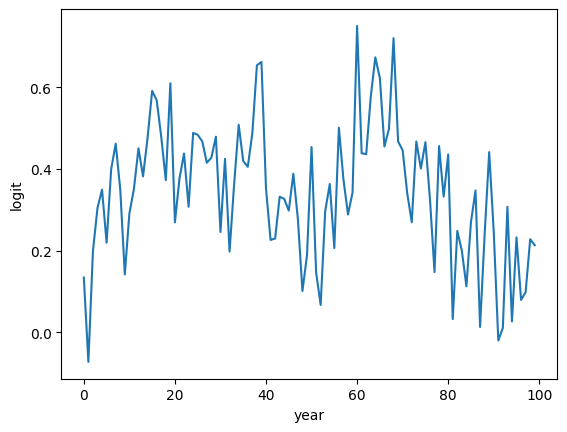

In [25]:
example_index = 0
layer = 0  # Set this to a layer index (0-11)
head = 0  # Set this to a head index (0-11) or to 'mlp'
plot_logit_lens(df['clean'][example_index], layer, head)

We can also apply it to MLPs! Which MLPs are important?

<details><summary> Find the circuit diagram here </summary>

![Here](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/circuit_diagram_gt41.png?raw=true)

</details>

The effect lasted from the year 1282 to the year 12


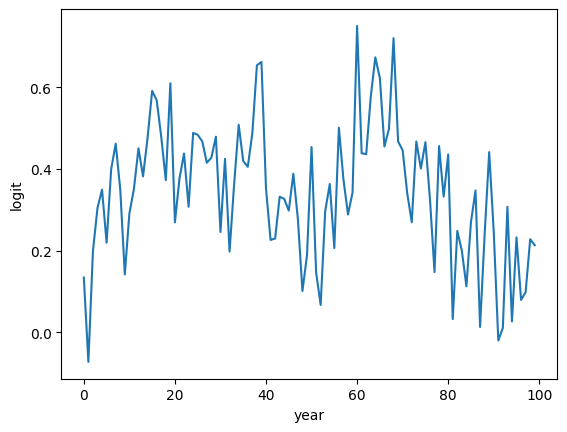

In [27]:
example_index = 0
layer = 0  # Set this to a layer index (0-11)
head = 0  # Set this to a head index (0-11) or to 'mlp'
plot_logit_lens(df['clean'][example_index], layer, head)

In the end, we can see how attention heads cause spikes at relevant years, while MLPs have a more general upweighting function. The latter point can be a bit hard to see; it becomes more clear if you aggregate logit lens results by year, and then plot the aggregations.

This is the end of this notebook! Now that you're done, check out the other one.

## 5. Bonus

Congratulations on finishing this notebook! Mechanistic interpretability is a large field, though, and we've only scratched the surface of it. Here are some interesting lines of work that you might want to look into when you're done with this.

- Circuits work:
    - in real language models:
        - [IOI](https://arxiv.org/abs/2211.00593)
        - [Greater-Than](https://arxiv.org/abs/2305.00586)
        - [Entity Tracking](https://openreview.net/forum?id=8sKcAWOf2D)
        - [Sentiment](https://arxiv.org/abs/2310.15154)
        - [QA in Chinchilla](https://arxiv.org/abs/2307.09458)
        - [Circuit Component Re-use](https://arxiv.org/abs/2310.08744)
    - in toy models:
        - [Grokking modular addition](https://openreview.net/forum?id=9XFSbDPmdW)
        - [Docstring circuit](https://www.lesswrong.com/posts/u6KXXmKFbXfWzoAXn/a-circuit-for-python-docstrings-in-a-4-layer-attention-only)
- Automated circuit finding work:
    - [Automated Circuit Discovery](https://arxiv.org/abs/2304.14997)
    - Edge Attribution Patching:
        - [original blog post](https://www.neelnanda.io/mechanistic-interpretability/attribution-patching)
        - [paper](https://arxiv.org/abs/2310.10348)
        - [AtP*, a follow-up](https://arxiv.org/abs/2403.00745)
        - EAP-IG (coming soon!)
- Studies of individual components:
    - [Successor Heads](https://openreview.net/pdf?id=kvcbV8KQsi)
    - [Copy Suppression](https://arxiv.org/abs/2310.04625)
- Mechanistic Interpretability Methods:
    - [Path Patching](https://arxiv.org/abs/2304.05969)
    - [Subspace Patching Illusions](https://arxiv.org/abs/2311.17030) and this [rebuttal](https://arxiv.org/abs/2401.12631)
    - [Best Practices in Activation Patching](https://openreview.net/forum?id=Hf17y6u9BC)
    - [Causal Scrubbing](https://www.alignmentforum.org/posts/JvZhhzycHu2Yd57RN/causal-scrubbing-a-method-for-rigorously-testing)
- Anthropic's work on mech. interp.:
    - [A Mathematical Framework for Circuits](https://www.anthropic.com/index/a-mathematical-framework-for-transformer-circuits), and a [recent update](https://www.anthropic.com/index/circuits-updates-may-2023)
    - [Induction Heads](https://www.anthropic.com/index/in-context-learning-and-induction-heads)
    - [Superposition](https://www.anthropic.com/index/toy-models-of-superposition) and [SoLU](https://www.anthropic.com/index/softmax-linear-units)
    - [Privileged Bases in the Residual Stream](https://www.anthropic.com/index/privileged-bases-in-the-transformer-residual-stream)

- Other cool (mostly) mechanistic work:
    - [ROME](https://arxiv.org/pdf/2202.05262.pdf) and this [follow-up](https://arxiv.org/pdf/2301.04213.pdf), plus more on fact retrieval: [paper 1](https://arxiv.org/abs/2304.14767) [paper 2](https://openreview.net/forum?id=P2gnDEHGu3) [paper 3](https://www.alignmentforum.org/posts/iGuwZTHWb6DFY3sKB/fact-finding-attempting-to-reverse-engineer-factual-recall)
    - [Interpreting a model trained to play Othello](https://arxiv.org/abs/2210.13382) and this [follow up](https://www.neelnanda.io/mechanistic-interpretability/othello).
    - The ["hydra effect"](https://arxiv.org/abs/2307.15771)
    - Chris Olah's [blog posts](https://distill.pub/2020/circuits/) on circuits in ConvNets

If you're looking for more notebooks or practice with TransformerLens, have a look at these:
- [Original Demo Notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb)
- [Intro to mechanistic interpretability (from ARENA)](https://arena3-chapter1-transformer-interp.streamlit.app/)